# Celltype annotation with SCSA
Single-cell transcriptomics allows the analysis of thousands of cells in a single experiment and the identification of novel cell types, states and dynamics in a variety of tissues and organisms. Standard experimental protocols and analytical workflows have been developed to create single-cell transcriptomic maps from tissues. 

This tutorial focuses on how to interpret this data to identify cell types, states, and other biologically relevant patterns with the goal of creating annotated cell maps.

Paper: [SCSA: A Cell Type Annotation Tool for Single-Cell RNA-seq Data](https://doi.org/10.3389/fgene.2020.00490)

Code: https://github.com/bioinfo-ibms-pumc/SCSA

Colab_Reproducibility：https://colab.research.google.com/drive/1RO6giAKFEsleaGAN8YIiA6M0QPJlhJuY?usp=sharing

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA can't be used in rare celltype annotations
  </p>
</div>

In [1]:
import omicverse as ov
import scanpy as sc
ov.utils.ov_plot_set()

## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation. We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [4]:
adata=ov.single.scanpy_lazy(adata)
adata

filtered out 19024 genes that are detected in less than 3 cells
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 35.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.3%
    Scrublet finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersi

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


AnnData object with n_obs × n_vars = 2659 × 1865
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/40053640) or [Google Drive](https://drive.google.com/file/d/1-eNpCAmt63X9G6l8MxvicwSUVvTKg5ec/view?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [14]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='cellmarker',
                          tissue='All',
)

...Creating directory temp
......Downloading dataset save to temp/pySCSA_2023.db
......[whole Size of file]: 13.89 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！7.158205032348633.2f s


In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden. if you are using louvain, please change it. And, we will annotate all clusters, if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format

In [15]:
scsa.cell_anno(clustertype='leiden',
               cluster='all')

ranking genes
    finished (0:00:01)
...Auto annotate cell
Version V2.0 [2023/04/07]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:96074,CancerSEA:1574,
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Namespace(Gensymbol=True, MarkerDB=None, celltype='normal', cluster='all', db='temp/pySCSA_2023.db', fc='/Users/fernandozeng/Library/Jupyter/runtime/kernel-b24c0b1a-8e42-4aad-b83f-34a4ca2cfa07.json', foldchange=1.5, input='temp/rna.csv', list_tissue=False, noprint=True, norefdb=False, outfmt='txt', output='temp/rna_anno.txt', pvalue=0.01, source='scanpy', species='Human', target='cellmarker', tissue='All', weight=100.0)
Version V2.0 [2023/04/07]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:96074,CancerSEA:1574,
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 80967
Cluster 0 Gene number: 31
Other Gene number: 964
Cluster 1 Gene number: 307
Other Gene number: 905
Cluster 2 Gene number: 109
Other Gene number: 895
Cluster 3 Gene number: 33
Other Gene number: 959
Cluster

,Cell Type,Z-score,Cluster
0,T cell,6.640116,0
1,Naive CD8+ T cell,5.228121,0
2,CD4+ T cell,4.402896,0
3,Naive CD4+ T cell,4.140157,0
4,CD8+ T cell,3.862066,0
...,...,...,...
1875,Myoblast,-0.245097,7
1876,Regulatory T(Treg) cell,-0.245097,7
1877,CD4+ T cell,-0.245924,7
1878,Beta cell(β cell),-0.246221,7


We can query only the better annotated results

In [16]:
scsa.cell_anno_print()

Cluster:0	Cell_type:T cell|Naive CD8+ T cell	Z-score:6.64|5.228
Cluster:1	Cell_type:Monocyte|Macrophage	Z-score:14.288|8.323
Nice:Cluster:2	Cell_type:Natural killer cell	Z-score:13.903
Cluster:3	Cell_type:T cell|CD4+ T cell	Z-score:8.949|5.04
Nice:Cluster:4	Cell_type:B cell	Z-score:13.776
Cluster:5	Cell_type:Monocyte|Macrophage	Z-score:11.193|9.117
Cluster:6	Cell_type:Dendritic cell|Monocyte	Z-score:9.324|6.05
Nice:Cluster:7	Cell_type:Megakaryocyte	Z-score:10.195


In addition to this, we can also auto-annotate cell types directly to the highest z-score, but this can have some problems. You can use `ov.single.scanpy_cellanno_from_dict` to annotate manually.

In [17]:
scsa.cell_auto_anno(adata)

...cell type added to scsa_celltype on obs of anndata


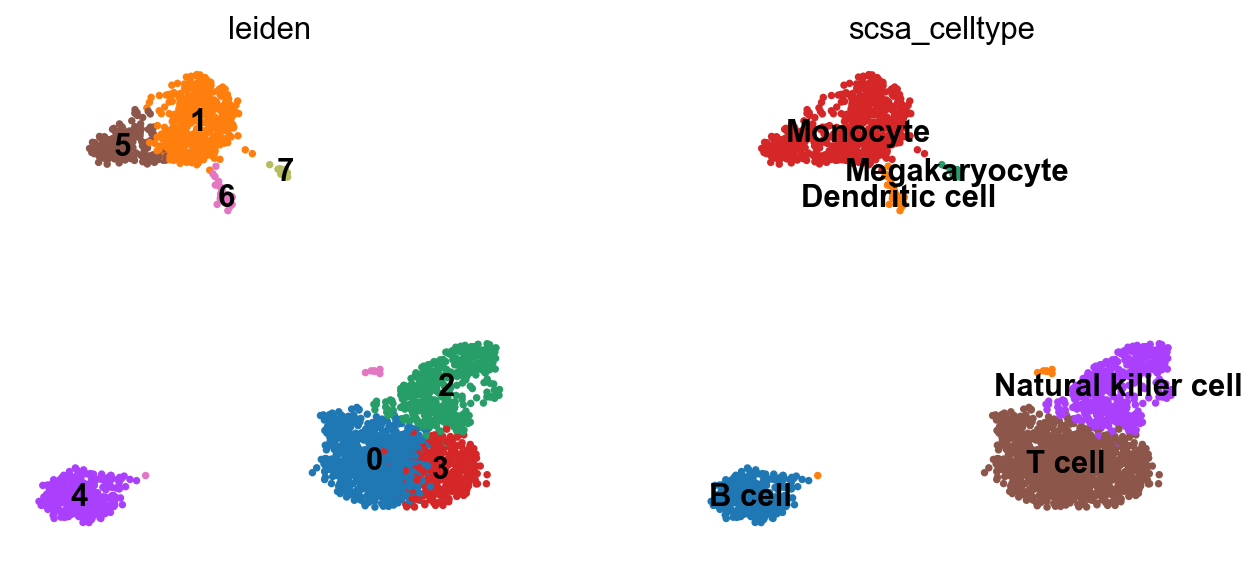

In [18]:
sc.pl.umap(adata, color=['leiden','scsa_celltype'], legend_loc='on data', frameon=False)

## Cell annotate manually

In order to compare the accuracy of our automatic annotations, we will here use marker genes to manually annotate the cluster and compare the accuracy of the pySCSA and manual.

We need to prepare a marker's dict at first

In [19]:
res_marker_dict={
    'Megakaryocyte':['ITGA2B','ITGB3'],
    'Dendritic cell':['CLEC10A','IDO1'],
    'Monocyte' :['S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1',],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],

}

We then calculated the expression of marker genes in each cluster and the fraction

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Megakaryocyte, Dendritic cell, Monocyte, etc.


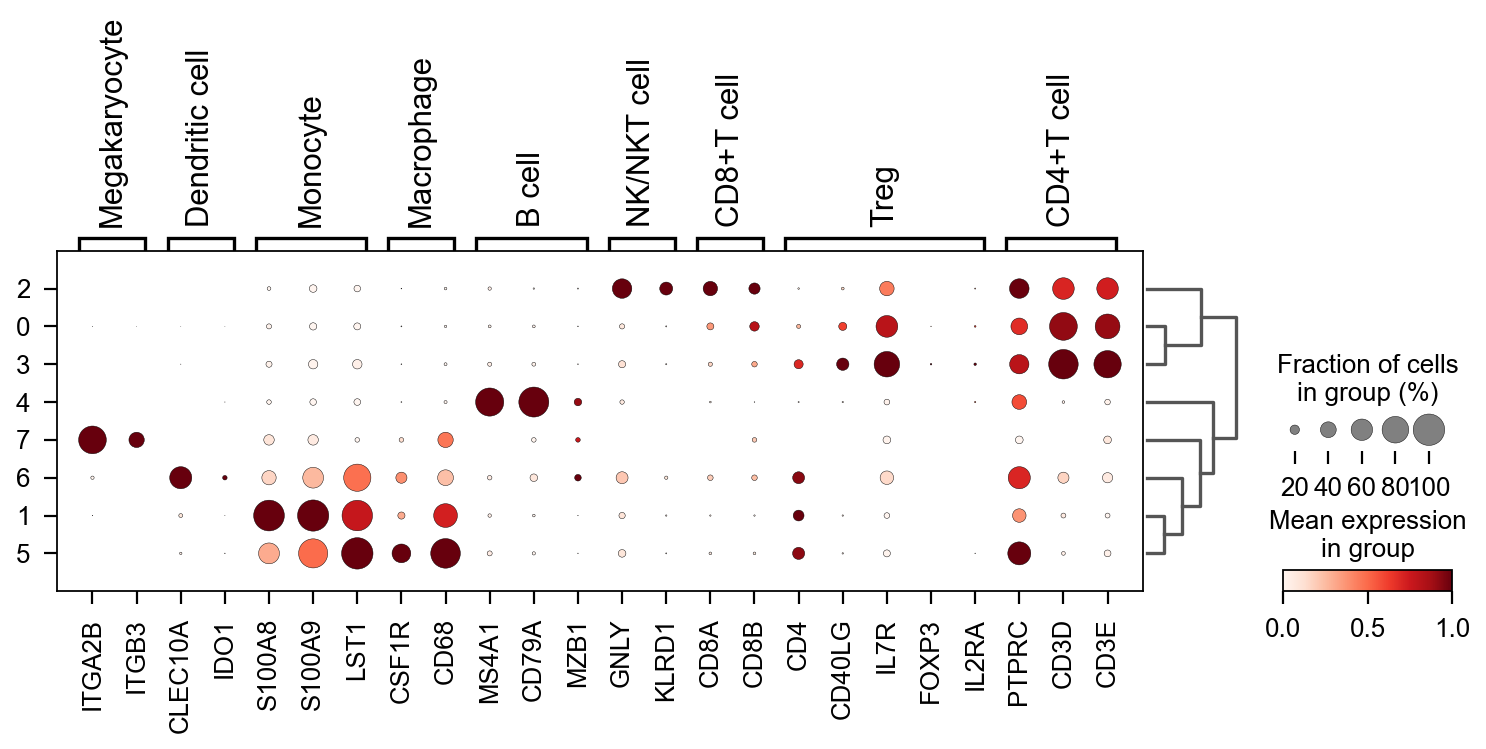

In [20]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden', dendrogram=True,standard_scale='var')

Based on the dotplot, we name each cluster according `ov.single.scanpy_cellanno_from_dict`

In [27]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'T cell',
     '1': 'Monocyte',
     '2': 'Natural killer T (NKT) cell',#Germ-cell(Oid)
     '3': 'T cell',#Germ-cell(Oid)
     '4': 'B cell',
     '5': 'Macrophage',
     '6': 'Dendritic cell',
     '7': 'Megakaryocyte',

}
ov.single.scanpy_cellanno_from_dict(adata,anno_dict=cluster2annotation,
                                       clustertype='leiden')

...cell type added to major_celltype on obs of anndata


## Compare the pySCSA and Manual

We can see that the auto-annotation results are almost identical to the manual annotation, the only difference is between monocyte and macrophages, but in the previous auto-annotation results, pySCSA gives the option of `monocyte|macrophage`, so it can be assumed that pySCSA performs better on the pbmc3k data

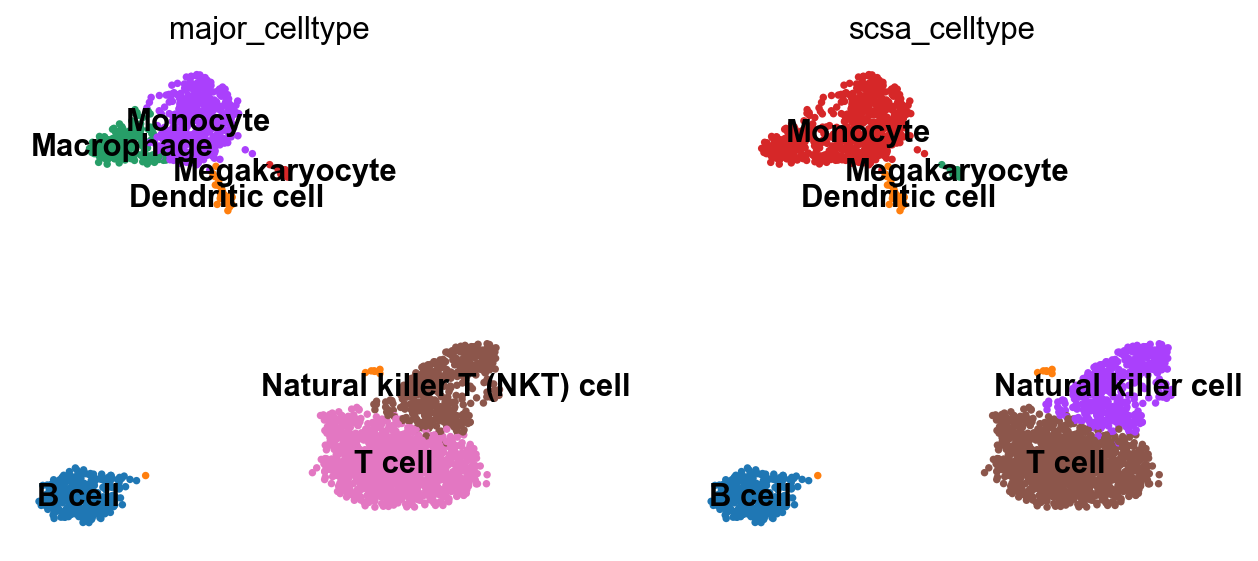

In [28]:
sc.pl.umap(adata, color=['major_celltype','scsa_celltype'], legend_loc='on data', frameon=False)

We can use `get_celltype_marker` to obtain the marker of each celltype

In [ ]:
marker_dict=ov.single.get_celltype_marker(adata,clustertype='scsa_celltype')
marker_dict.keys()

## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [29]:
scsa.get_model_tissue()

Version V2.0 [2023/04/07]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:96074,CancerSEA:1574,
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:312       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                            12: Amniotic 

SystemExit: 0